# Data Retrieval

In [1]:
import pandas as pd

def data_retrieval(filepath):
    df = pd.read_csv(filepath)
    return df

df = data_retrieval('gutenberg_expanded.csv')
print(df)

       Unnamed: 0   author  label  \
0               0   austen      0   
1               1   austen      0   
2               2   austen      0   
3               3   austen      0   
4               4   austen      0   
...           ...      ...    ...   
18888       18888  whitman     11   
18889       18889  whitman     11   
18890       18890  whitman     11   
18891       18891  whitman     11   
18892       18892  whitman     11   

                                                    text  
0      [Emma Jane Austen 1816] VOLUME I CHAPTER I Emm...  
1      Even Miss Taylor ceased hold nominal office go...  
2      It wedding-day beloved friend Emma sat mournfu...  
3      The want Miss Taylor felt hour day.She recalle...  
4      She dearly loved father, companion her.He meet...  
...                                                  ...  
18888  Mirages More experiences sights, stranger, you...  
18889  The Unexpress'd How dare it?After cycles, poem...  
18890  More evolutionary

# Data Analysis

In [2]:
import numpy as np
# determining average word count per text
word_count = []
for i in df['text'].values:
    word_count.append(len(i.split()))
word_count = np.array(word_count)

In [3]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [5]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 875
Mean: 55.006351558778384
Median 49.0
1st percentile 8.0
95th percentile 115.0
99th percentile 181.0799999999981
99.5th Percentile 221.0
99.9th Percentile 319.0800000000381


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

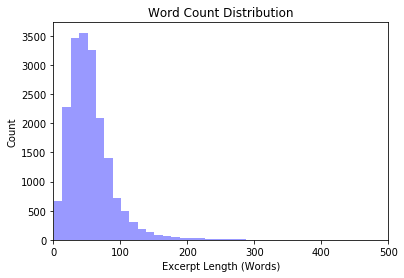

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 500)
plt.savefig("word_count.eps")

# Splitting the Data

In [11]:
from sklearn.model_selection import train_test_split
text = df['text'].values
labels = df['label'].values
# splitting data into 80-20 for training and testing
text_train, text_test_val, label_train, label_test_val = train_test_split(text,labels, test_size = 0.2, random_state = 42)
# splitting testing data into 50-50 for testing and validation
text_test, text_val, label_test, label_val = train_test_split(text_test_val, label_test_val, test_size=.5, random_state=42)
print(text_train.shape, label_train.shape)
print(text_test.shape, label_test.shape)
print(text_val.shape, label_val.shape)

(15114,) (15114,)
(1889,) (1889,)
(1890,) (1890,)


# Text Processing
## Input

In [12]:
from gensim.parsing.preprocessing import remove_stopwords

# removing stop words
def remove_stop_words_preprocessing(text_values):
    for i in range(len(text_values)):
        text_values[i] = remove_stopwords(text_values[i].lower())
    return text_values

In [13]:
# word embeddings
from keras.preprocessing.text import Tokenizer

def word_embeddings(text_values):
    tokenizer = Tokenizer(num_words=5000, oov_token="UNK")
    tokenizer.fit_on_texts(text_values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return tokenizer

In [14]:
# Removing the stop words
X = remove_stop_words_preprocessing(text_train)
X_val_text = remove_stop_words_preprocessing(text_val)
X_test_text = remove_stop_words_preprocessing(text_test)

# Creating a tokenization
tokenizer = word_embeddings(X)

# Tokenizing the sentences
X_train = tokenizer.texts_to_sequences(X)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

Found 41126 unique tokens.


In [15]:
# vocab size
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

41127


In [16]:
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = 80
X_train = pad_sequences(X_train, padding="post", maxlen=max_sequence_length)
X_val = pad_sequences(X_val, padding="post", maxlen=max_sequence_length)
X_test = pad_sequences(X_test, padding="post", maxlen=max_sequence_length)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (15114, 80)


## Output

In [17]:
Y_train = pd.get_dummies(label_train).values
Y_val = pd.get_dummies(label_val).values
Y_test = pd.get_dummies(label_test).values
print('Shape of label tensor: ', Y_train.shape)

Shape of label tensor:  (15114, 12)


# Keras Modeling

In [18]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, 
                   output_dim=embedding_dim,
                  input_length=max_sequence_length))
model.add(layers.SpatialDropout1D(0.2))

model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(12, activation='softmax'))
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            2056350   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 80, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 2,117,962
Trainable params: 2,117,962
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, Y_train, 
                    epochs=10, 
                    validation_data=(X_val, Y_val),
                    batch_size=25)

C:\Users\shris\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15114 samples, validate on 1890 samples
Epoch 1/10
15114/15114 [==============================] - 106s 7ms/step - loss: 1.6846 - accuracy: 0.4172 - val_loss: 1.4291 - val_accuracy: 0.4857
Epoch 2/10
15114/15114 [==============================] - 95s 6ms/step - loss: 1.4188 - accuracy: 0.5237 - val_loss: 1.2486 - val_accuracy: 0.6201
Epoch 3/10
15114/15114 [==============================] - 93s 6ms/step - loss: 1.4380 - accuracy: 0.5251 - val_loss: 1.1121 - val_accuracy: 0.6286
Epoch 4/10
15114/15114 [==============================] - 94s 6ms/step - loss: 1.0165 - accuracy: 0.6350 - val_loss: 0.8417 - val_accuracy: 0.6947
Epoch 5/10
15114/15114 [==============================] - 93s 6ms/step - loss: 0.8593 - accuracy: 0.6919 - val_loss: 0.7529 - val_accuracy: 0.7243
Epoch 6/10
15114/15114 [==============================] - 97s 6ms/step - loss: 0.7233 - accuracy: 0.7436 - val_loss: 0.6622 - val_accuracy: 0.7667
Epoch 7/10
15114/15114 [==============================] - 96s 6ms/st

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

accuracy = model.evaluate(X_test, Y_test)
prediction = model.predict(X_test)
confusion_matrix = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1))
print(confusion_matrix)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

1889/1889 [==============================] - 2s 861us/step
[[285   0   0   0   0   0   3  11   1   0   1   0]
 [  0 613   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   3   1   2]
 [  0   0   0  34   0   4   3  13   2   0   2   0]
 [  0   0   0   1   2  13   1   1   0   0   0   0]
 [  0   0   0   0   2  21   3   4   0   0   1   0]
 [  0   0   0   3   0   0 215  11  14   0   1   1]
 [  6   0   0   1   0   0   3 193   2   0   0   0]
 [  0   0   0   1   0   0   8   1 192   0   1   3]
 [  0   0   0   0   0   0   0   0   0  23   0   9]
 [  0   1   0   0   0   0   0   0   0   0  95   0]
 [  0   0   0   0   0   0   1   1  20   3   2  50]]
Test set
  Loss: 0.267
  Accuracy: 0.912


## Comparing Against Other Models

In [ ]:
# Logistics Regression

In [ ]:
# Multinomial / Binomial

In [ ]:
# Ngram Distribution Testing

In [ ]:
# SVM Model